In [ ]:
from google.colab import drive  
drive.mount('/content/drive')         

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import fastai                                   
import torch                                  
from fastai import *                          
from fastai.vision import *                 
# from fastai.vision import *                    
from fastai.callbacks import *               
from fastai.utils.mem import *               
from torchvision.models import vgg16_bn 

In [ ]:
# Putting everything in 2 folders input and targets. 

# import shutil
# import os
# dest = '/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Target_'
# for v in os.scandir('/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Target_vald'):
#   shutil.move(v.path,dest)
# entrypoints = torch.hub.list('pytorch/vision:v0.5.0', force_reload=True)
import torchvision
torchvision.__version__

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"      

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 41.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [ ]:
bs,size=32,180


label = '/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Target/'
img_to_img = lambda x : label+x.stem+x.suffix
il = ImageImageList.from_folder('/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Input2')       
ll = il.split_by_rand_pct(valid_pct=0.2,seed = 23).label_from_func(img_to_img)
data = ll.transform(get_transforms(max_rotate=None, max_zoom=1, max_lighting=None, max_warp=None), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True)

In [ ]:
# path = untar_data(URLs.PETS)
# path_hr = path/'images'
# path_lr = path/'small-96'
# path_mr = path/'small-256'

In [ ]:
# il = ImageList.from_folder(path_hr)

In [ ]:
# def resize_one(fn, i, path, size):
#     dest = path/fn.relative_to(path_hr)
#     dest.parent.mkdir(parents=True, exist_ok=True)
#     img = PIL.Image.open(fn)
#     targ_sz = resize_to(img, size, use_min=True)
#     img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
#     img.save(dest, quality=60)

In [ ]:
# # create smaller image sets the first time this nb is run
# sets = [(path_lr, 96), (path_mr, 256)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

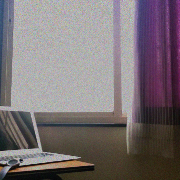

In [ ]:
data.train_ds[0][0]

In [ ]:
# def get_data(bs,size):
#     data = (src.label_from_func(lambda x: path_hr/x.name)
#            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
#            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

#     data.c = 3
#     return data

In [ ]:
# data = get_data(bs,size)     

In [ ]:
t = data1.valid_ds[0][1].data     # valid_ds gives you data with input and target 
t = torch.stack([t,t])           # and dl gives you generator which you can iterate

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)          

In [ ]:
gram_matrix(t)

tensor([[[0.0955, 0.0898, 0.0911],
         [0.0898, 0.0848, 0.0867],
         [0.0911, 0.0867, 0.0901]],

        [[0.0955, 0.0898, 0.0911],
         [0.0898, 0.0848, 0.0867],
         [0.0911, 0.0867, 0.0901]]])

In [ ]:
base_loss = F.l1_loss

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


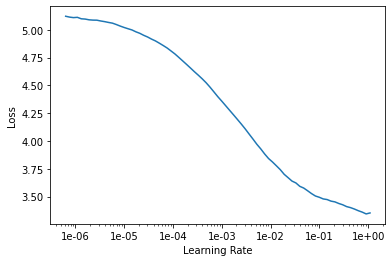

In [ ]:
learn.lr_find()
learn.recorder.plot()      

In [ ]:
lr = 7e-4
# slice(lr*10)

In [ ]:
def do_fit(save_name, lrs, pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,4.246846,3.436070,0.395151,0.273995,0.325425,0.129671,0.970196,1.097641,0.243991,01:59
1,3.599321,2.776535,0.191640,0.243746,0.288410,0.112671,0.779799,0.932794,0.227474,01:04
2,3.164603,2.296316,0.138908,0.211218,0.242780,0.090975,0.641718,0.779207,0.191510,01:04
3,2.823565,2.073336,0.137346,0.194181,0.216049,0.080481,0.585376,0.692589,0.167314,01:03
4,2.563139,1.914826,0.136871,0.186014,0.199969,0.072492,0.541574,0.631495,0.146411,01:03
5,2.361650,1.719296,0.139114,0.164752,0.185866,0.065191,0.464538,0.567650,0.132185,01:03
6,2.225075,1.624607,0.124101,0.162340,0.176753,0.063005,0.442533,0.527278,0.128597,01:03
7,2.105390,1.658181,0.159108,0.158825,0.177946,0.071927,0.414954,0.520943,0.154478,01:04
8,2.015532,1.543683,0.128278,0.151242,0.172072,0.058248,0.388127,0.527206,0.118511,01:04
9,1.900759,1.309325,0.148976,0.131676,0.144522,0.054644,0.295262,0.418769,0.115476,01:04


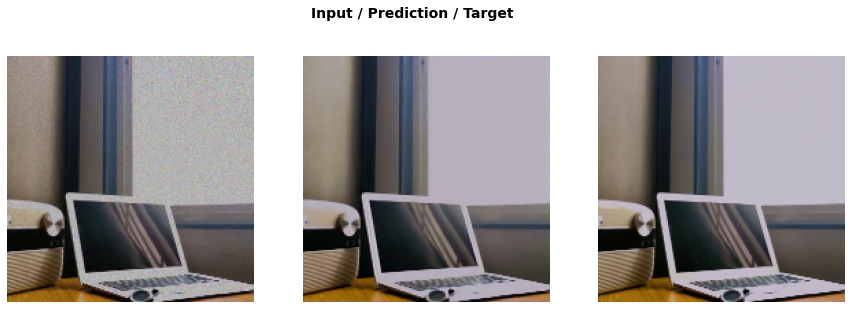

In [ ]:
do_fit('1a', slice(lr*10))          

In [ ]:
learn.unfreeze()                  # unfreeze always has a slice
# learn.recorder.plot_losses()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.246342,1.167622,0.107390,0.125064,0.136581,0.051484,0.258621,0.378926,0.109556,01:04
1,1.194805,1.081273,0.107685,0.118325,0.128599,0.048766,0.226798,0.347597,0.103503,01:04
2,1.143756,1.010101,0.098978,0.110890,0.122121,0.047598,0.197181,0.330211,0.103122,01:04
3,1.098894,0.944826,0.095058,0.105685,0.115873,0.044794,0.171321,0.315187,0.096909,01:03
4,1.089888,1.322056,0.116608,0.124258,0.150122,0.051148,0.308864,0.463210,0.107846,01:04
5,1.100327,1.172648,0.110201,0.121824,0.134592,0.053880,0.256498,0.376129,0.119524,01:03
6,1.155878,1.437913,0.139784,0.136712,0.162812,0.065137,0.313810,0.479193,0.140465,01:04
7,1.199740,1.159760,0.124977,0.118325,0.135442,0.054258,0.234378,0.377765,0.114615,01:04
8,1.209392,1.231033,0.130487,0.121023,0.141099,0.054848,0.244783,0.417438,0.121354,01:04
9,1.195537,1.004958,0.114984,0.108296,0.120430,0.047301,0.180907,0.331278,0.101762,01:04


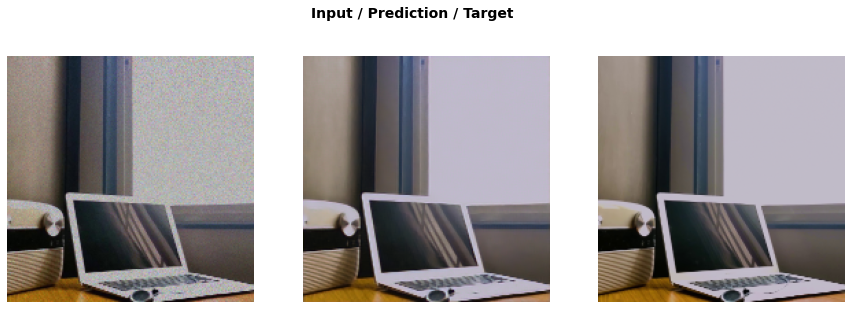

In [ ]:
do_fit('1b', slice(lr,lr*10))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


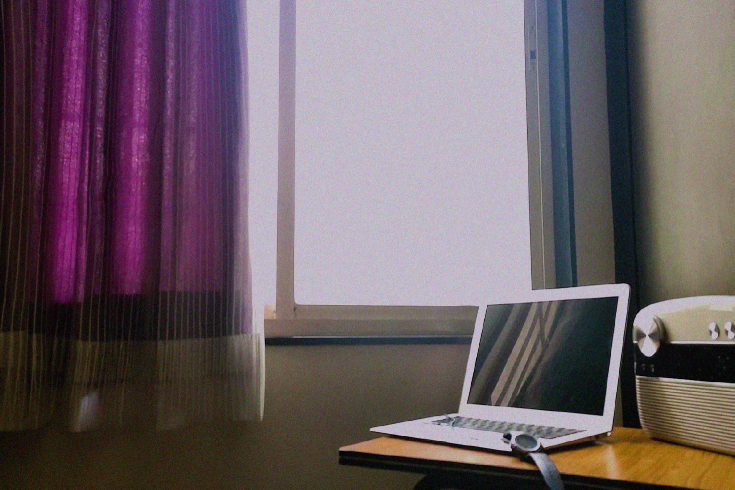

In [ ]:
data1.train_ds[0][0]   

## Second round - where the model is trained on the increased image size.

In [ ]:
# data = get_data(12,size*2)

bs,size=2,(576,1024)


label = '/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Target/'
img_to_img1 = lambda x : label+x.stem+x.suffix
il1 = ImageImageList.from_folder('/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Input')       
ll1 = il1.split_by_rand_pct(valid_pct=0.2,seed = 23).label_from_func(img_to_img1)                                   
data1 = ll1.transform(get_transforms(max_rotate=None, max_zoom=1, max_lighting=None, max_warp=None), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [ ]:
arch = models.resnet34


t = data2.valid_ds[0][1].data     # valid_ds gives you data with input and target 
t = torch.stack([t,t])           # and dl gives you generator which you can iterate

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)          


gram_matrix(t)


base_loss = F.l1_loss


vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)


blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()


feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])



In [ ]:
def do_fit(save_name, lrs, pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)                  

In [ ]:
lr = 7e-4

In [ ]:
wd = 1e-3
learn = unet_learner(data1, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns= [LossMetrics , partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.006, patience=2)], 
                     blur=True, norm_type=NormType.Weight)
gc.collect(); 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
learn.load('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/saved_weights224r');    

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.567555,0.572306,0.086796,0.153337,0.119852,0.034673,0.072120,0.076544,0.028983,11:46
1,0.546702,0.559459,0.087854,0.151650,0.117158,0.033365,0.068357,0.073515,0.027560,10:53
2,0.545359,0.539551,0.084157,0.150203,0.114034,0.032194,0.063553,0.069216,0.026195,10:53
3,0.534971,0.541146,0.085957,0.149109,0.113227,0.031700,0.065652,0.069839,0.025661,10:53
4,0.535872,0.533980,0.084269,0.149257,0.111409,0.031350,0.064428,0.067980,0.025286,10:53


Epoch 5: early stopping


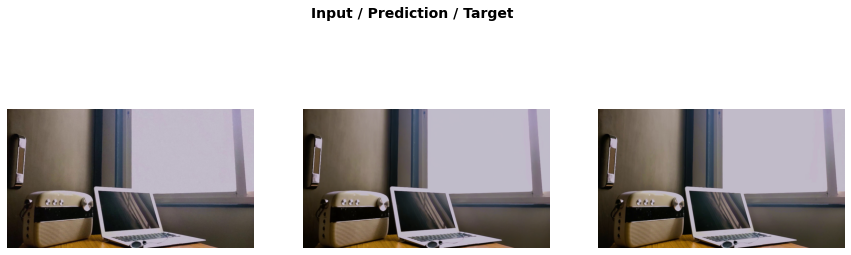

In [ ]:
do_fit('2a_576',slice(lr*10))       

In [ ]:
learn.save('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/saved_weights576')

In [ ]:
learn.export('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/saved_model576.pkl')

In [ ]:
learn.unfreeze()

0.0007

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.691972,0.645398,0.073634,0.089315,0.092810,0.036182,0.085936,0.197757,0.069763,01:12
1,0.682371,0.642442,0.073801,0.088412,0.092093,0.035770,0.086820,0.196832,0.068715,01:12
2,0.676205,0.648504,0.074297,0.089025,0.092729,0.036175,0.088239,0.198365,0.069674,01:12
3,0.678439,0.667995,0.077127,0.090330,0.093951,0.035927,0.098975,0.202544,0.069141,01:12
4,0.700855,0.704874,0.080436,0.091798,0.097695,0.037457,0.102642,0.223374,0.071470,01:12
5,0.724846,0.735345,0.080962,0.095026,0.101569,0.038007,0.114020,0.232950,0.072810,01:13
6,0.749953,0.767672,0.089925,0.097743,0.103680,0.038730,0.132527,0.231569,0.073498,01:13
7,0.875249,1.302611,0.136746,0.130448,0.158515,0.053040,0.263126,0.465110,0.095628,01:13
8,0.925105,0.846575,0.098160,0.103388,0.112568,0.044419,0.147230,0.255884,0.084924,01:14
9,0.868273,0.672883,0.074546,0.092140,0.096760,0.037251,0.096225,0.205113,0.070847,01:14


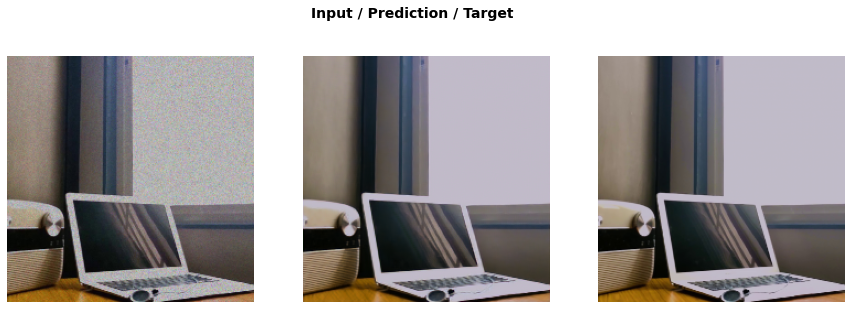

In [ ]:
do_fit('2b',slice(lr,1e-2))

## On new Images

In [ ]:
bs,size=1,(576,1024)



label = '/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Target/'
img_to_img2 = lambda x : label+x.stem+x.suffix
il2 = ImageImageList.from_folder('/content/drive/My Drive/Colab_Notebooks/Noise_reduction/Input')       
ll2 = il2.split_by_rand_pct(valid_pct=0.2,seed = 23).label_from_func(img_to_img2)
data2 = ll2.transform(get_transforms(max_rotate=None, max_zoom=1, max_lighting=None, max_warp=None), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True)

data2.c = 3

In [ ]:
arch = models.resnet34


t = data2.valid_ds[0][1].data     # valid_ds gives you data with input and target 
t = torch.stack([t,t])           # and dl gives you generator which you can iterate

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)          


gram_matrix(t)


base_loss = F.l1_loss


vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)


blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()


feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [ ]:
learn = None  
gc.collect(); 
learn = unet_learner(arch = arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
learn.load('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/saved_weights576')

In [ ]:
img = open_image('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/cropped.JPG'); img.shape   
# fro passing a tensor in the model we wil use fastai open_image and show_image.

torch.Size([3, 576, 1024])

1.7777777777777777

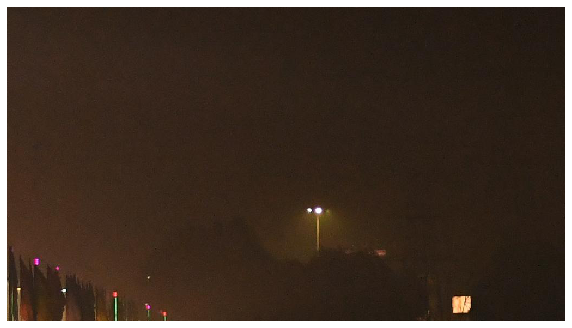

In [ ]:
show_image(img, figsize=(10,17), interpolation='nearest')  
img.shape[2]/img.shape[1]

In [ ]:
%%time
p,img_hr,b = learn.predict(img)     # you can predict single image with open_image() function.   

CPU times: user 513 ms, sys: 81.1 ms, total: 594 ms
Wall time: 595 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25.5

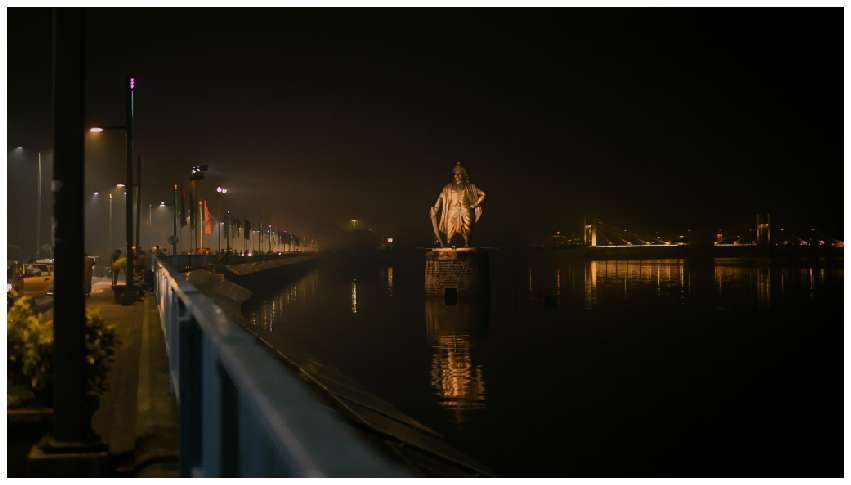

In [ ]:
show_image(img_hr , figsize=(15,17),interpolation='nearest') 
# open_image(img_hr) 
img_hr.shape 
15*1.7                           

In [ ]:
# Cropping an Image
# img = Image.open('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/ACS_5370.JPG')
# cropped = (img.crop((2000,1500,2000+1024,1500+576)))
# cropped.save('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/cropped.JPG')
img

In [ ]:
learn = load_learner('/content/drive/My Drive/Colab_Notebooks/U nets pytorch','saved_model576.hdf5')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

In [ ]:
img = open_image('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/Image_samples/input.jpg')
learn.predict(img)[0]

### Deploying

In [ ]:
import torch
aer = torch.load('/content/drive/My Drive/Colab_Notebooks/U nets pytorch/saved_model576.hdf5')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

In [ ]:
import torch.nn as nn
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()



# feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

def get_sfs_idxs(sfs, last=True):
    """
    Return the saved feature indexes that will be concatenated
    Inputs:
        sfs (list): saved features by hook function, in other words intermediate activations
        last (bool): whether to concatenate only last different activation, or all from the encoder model
    """
    if last:
        feature_szs = [sfs_feats.features.size()[-1] for sfs_feats in sfs]
        sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
        if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    else: sfs_idxs = list(range(len(sfs)))
    return sfs_idxs


def conv_bn_relu(in_c, out_c, kernel_size, stride, padding):
    return [
        nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_c)]


class UnetBlock(nn.Module):
    #TODO: ADAPT KERNEL SIZE, STRIDE AND PADDING SO THAT ANY SIZE DECAY WILL BE SUPPORTED
    def __init__(self, up_in_c, x_in_c):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(up_in_c, up_in_c // 2, 2, 2) # H, W -> 2H, 2W
        self.conv1 = nn.Conv2d(x_in_c + up_in_c // 2, (x_in_c + up_in_c // 2) // 2, 3, 1, 1)
        self.conv2 = nn.Conv2d((x_in_c + up_in_c // 2) // 2, (x_in_c + up_in_c // 2) // 2, 3, 1, 1)
        self.bn = nn.BatchNorm2d((x_in_c + up_in_c // 2) // 2)

    def forward(self, up_in, x_in):
        up_out = self.upconv(up_in)
        cat_x = torch.cat([up_out, x_in], dim=1)
        x = F.relu(self.conv1(cat_x))
        x = F.relu(self.conv2(x))
        return self.bn(x)

class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()


class DynamicUnet(nn.Module):
    """
    A dynamic implementation of Unet architecture, because calculating connections
    and channels suck!. When an encoder is passed, this network will
    automatically construct a decoder after the first single forward pass for any
    given encoder architecture.
    Decoder part is heavily based on the original Unet paper:
    https://arxiv.org/abs/1505.04597.
    Inputs:
        encoder(nn.Module): Preferably a pretrained model, such as VGG or ResNet
        last (bool): Whether to concat only last activation just before a size change
        n_classes (int): Number of classes to output in final step of decoder
    Important Note: If architecture directly reduces the dimension of an image as soon as the
    first forward pass then output size will not be same as the input size, e.g. ResNet.
    In order to resolve this problem architecture will add an additional extra conv transpose
    layer. Also, currently Dynamic Unet expects size change to be H,W -> H/2, W/2. This is
    not a problem for state-of-the-art architectures as they follow this pattern but it should
    be changed for custom encoders that might have a different size decay.
    """

    def __init__(self, encoder, last=True, n_classes=3):
        super().__init__()
        self.encoder = encoder
        self.n_children = len(list(encoder.children()))
        self.sfs = [SaveFeatures(encoder[i]) for i in range(self.n_children)]
        self.last = last
        self.n_classes = n_classes

    def forward(self, x):
        dtype = x.data.type()

        # get imsize
        imsize = x.size()[-2:]

        # encoder output
        x = F.relu(self.encoder(x))

        # initialize sfs_idxs, sfs_szs, middle_in_c and middle_conv only once
        if not hasattr(self, 'middle_conv'):
            self.sfs_szs = [sfs_feats.features.size() for sfs_feats in self.sfs]
            self.sfs_idxs = get_sfs_idxs(self.sfs, self.last)
            middle_in_c = self.sfs_szs[-1][1]
            middle_conv = nn.Sequential(*conv_bn_relu(middle_in_c, middle_in_c * 2, 3, 1, 1),
                                        *conv_bn_relu(middle_in_c * 2, middle_in_c, 3, 1, 1))
            self.middle_conv = middle_conv.type(dtype)

        # middle conv
        x = self.middle_conv(x)

        # initialize upmodel, extra_block and 1x1 final conv
        if not hasattr(self, 'upmodel'):
            x_copy = Variable(x.data, requires_grad=False)
            upmodel = []
            for idx in self.sfs_idxs[::-1]:
                up_in_c, x_in_c = int(x_copy.size()[1]), int(self.sfs_szs[idx][1])
                unet_block = UnetBlock(up_in_c, x_in_c).type(dtype)
                upmodel.append(unet_block)
                x_copy = unet_block(x_copy, self.sfs[idx].features)
                self.upmodel = nn.Sequential(*upmodel)

            if imsize != self.sfs_szs[0][-2:]:
                extra_in_c = self.upmodel[-1].conv2.out_channels
                self.extra_block = nn.ConvTranspose2d(extra_in_c, extra_in_c, 2, 2).type(dtype)

            final_in_c = self.upmodel[-1].conv2.out_channels
            self.final_conv = nn.Conv2d(final_in_c, self.n_classes, 1).type(dtype)

        # run upsample
        for block, idx in zip(self.upmodel, self.sfs_idxs[::-1]):
            x = block(x, self.sfs[idx].features)
        if hasattr(self, 'extra_block'):
            x = self.extra_block(x)

        out = self.final_conv(x)
        return out